# Compare SNOTEL precipitation observations to CW3E forcing
D. Tijerina, 5/2023

This script reads in SNOTEL total, daily precipitation (mm) observations queried from Hydrodata and compares to CW3E forcing. The notebook is broken up into these sections:  
1. Read in SNOTEL observations and metadata; organize into pandas dataframes
2. Read in CW3E forcing over CONUS2 and extract indices for CONUS2 grid cells that are common to the SNOTEL observations;  organize all data
3. Compute statistics between CW3E and SNOTEL observations
4. Create summary plots, maps, and individual station timeseries


Inputs:
- SNOTEL Metadata csv file of stations from a Hydrodata query (from point_observations.ipynb)
- SNOTEL Observation data csv file of stations from a Hydrodata query (from point_observations.ipynb)

Outputs:
- Matched CW3E/ParFlow temperature csv
- Rematched Metadata file csv
- Rematched SNOTEL observation file csv
- Summary station SNOTEL csv containing station info, CONUS x and y, averages, statistics
- Timeseries of SNOTEL variable vs. ParFlow at individual stations
- Summary plots/maps

Notes: 
- Need to add a basemap to summary plots (Geopandas? Basemap from matplot.toolkit?)

In [1]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd

##### Change paths to directories, run information...

In [2]:
### Directory to save CSV outputs
#organized_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Organized_csv' # verde
organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Organized_csv' # cheyenne

### Where you want to save plots, etc. to
#plot_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Figures' # verde
plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/SNOTEL/precip_temp/Figures' # hydrodata
plot_dir = '/hydrodata/temp/CONUS2_transfers/CONUS2/Validation_Data/SNOTEL/precip_temp/Figures' # cheyenne



### need to change water year and number of days
water_year = 2003
no_days = 365 
variable = 'CONUS2_Precip_tot'

### CONUS2 domain
ny = 3256
nx = 4442

##### Names of observation csv files, these are usually saved from Hydrodata

In [3]:
### Files for SNOTEL total precip observations from Hydrodata
data_file = 'Hydrodata_precipitation_obs_daily_total_WY2003.csv' 
metadata_file = 'Hydrodata_precipitation_metadata_daily_total_WY2003.csv'

##### Name of path and file name of PFB reading in
CW3E (CONUS2 Forcing)

In [4]:
# path to daily forcing PFB files
pfb_read_path = '/hydrodata/forcing/processed_data/CONUS2/NLDAS3/daily/WY2003'
# This is the partial name of the pfb, without the timestamp or .pfb file extension
# (for example, 'NLDAS.APCP.daily.sum.008.pfb' -> 'NLDAS.APCP.daily.sum')
pfb_name = 'NLDAS.APCP.daily.sum' 

##### Create file names for all files you will save out
These include:
- CSV of ParFlow or CW3E modeled values from pfb at station-matched CONUS2 x, y
- Rematched observation csv file (this is a reorganized version of `data_file`
- Rematched observation metadata csv file (this is a reorganized version of `metadata_file`
- Summary statistics csv with station info and stats for each station

In [5]:
### Name files you will save out
# names of csv files for model and observations that contain the same stations
pf_matched_csv = f'CW3E_Daily_matched_{variable}_{water_year}.csv'
snotel_matched_csv = f'SNOTEL_Daily_matched_{variable}_{water_year}.csv'
metadata_matched_csv = f'SNOTEL_metadata_matched_{variable}_{water_year}.csv'
# summary stats
summary_stats_csv = f'Summary_Stations_SNOTEL_{variable}_CONUS2_WY{water_year}.csv'

##### Other things that likely need to be changed
- names of plots saved out  are named within in the plotting function
- same for some specifics of the plot titles

# 1. Read in SNOTEL observations and organize

### SNOTEL Total Daily Precipitation

In [4]:
obs_data = pd.read_csv(f'{organized_dir}/{data_file}', index_col=['site_id'])
obs_data  = obs_data.drop(columns=['Unnamed: 0'])
obs_data = obs_data.loc[(obs_data['num_obs']>340)] # I arbitrarily set this to only include sites with more than 340 days of observations
obs_data

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.00,0.00,7.62,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365
1005:CO:SNTL,7.62,10.16,0.00,2.54,0.00,0.00,0.00,0.0,2.54,0.00,...,0.00,2.54,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365
1006:NV:SNTL,5.08,0.00,10.16,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365
1008:MT:SNTL,2.54,0.00,0.00,0.00,5.08,0.00,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365
1009:MT:SNTL,0.00,0.00,2.54,0.00,5.08,2.54,0.00,0.0,0.00,0.00,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,0.00,0.00,2.54,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,2.54,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365
988:ID:SNTL,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,2.54,...,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365
989:ID:SNTL,2.54,2.54,5.08,0.00,0.00,0.00,2.54,0.0,0.00,0.00,...,2.54,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,365


In [5]:
metadata = pd.read_csv(f'{organized_dir}/{metadata_file}', index_col=['site_id'])
metadata  = metadata.drop(columns=['Unnamed: 0'])
# also remove the sites with less than 340 obs from the metadata
metadata = metadata[metadata.index.isin(obs_data.index)]
# add number of observations column from the obs_data df
metadata['num_obs'] = obs_data['num_obs']
obs_data = obs_data.drop(columns=['num_obs'])
metadata

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,SNOTEL station,NRCS,Annie Springs,1000:OR:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,42.87007,-122.16518,OR,180102030101,...,/hydrodata/national_obs/point_meteorology/NRCS...,Klamath,6010.0,ANSO3,22G06S,NaN,NaN,258,2286,365
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,/hydrodata/national_obs/point_meteorology/NRCS...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448,365
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,/hydrodata/national_obs/point_meteorology/NRCS...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908,365
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499,365
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,SNOTEL station,NRCS,Sourdough Gulch,985:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.23718,-117.39438,WA,170601030202,...,/hydrodata/national_obs/point_meteorology/NRCS...,Asotin,4000.0,SGUW1,17C06S,245.0,1601.0,709,2531,365
988:ID:SNTL,SNOTEL station,NRCS,Hidden Lake,988:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,48.89370,-116.75748,ID,170101040502,...,/hydrodata/national_obs/point_meteorology/NRCS...,Boundary,5040.0,HDLI1,16A12S,361.0,1879.0,825,2796,365
989:ID:SNTL,SNOTEL station,NRCS,Moscow Mountain,989:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.80500,-116.85350,ID,170603061002,...,/hydrodata/national_obs/point_meteorology/NRCS...,Latah,4700.0,MSCI1,16C02S,300.0,1653.0,763,2580,365


# 2. Read in CW3E forcing and organize

In [7]:
# make CONUS2 x and y into arrays for the for loop
conusy = np.asarray(metadata['conus2_y'],dtype = 'int')
conusx = np.asarray(metadata['conus2_x'],dtype = 'int')

#### Read in pfb and extract data at each CONUS2 index pair included in the observations/metadata files
Precipitation forcing files are daily sum

In [ ]:
# Total Preciptiation
# Set up arrays 
pf_full_array = np.zeros((no_days, ny, nx))
pf_matched = np.zeros(obs_data.shape)

### READ STREAMFLOW PFBs ###
#Read in CONUS2 daily streamflow PFBs and save as df in flow_df, convert to total accumulated in m^3/h to mean daily in cms
for i in range(no_days):
    step = str(int(i+1)).rjust(3, '0')
    ### CHECK THIS PATH TO CONFIRM CORRECT OBS FILE ###
    pf_pfb = np.squeeze(read_pfb(f'{pfb_read_path}/{pfb_name}.{step}.pfb'))
    pf_full_array[i,...] = pf_pfb
    print(f'reading {variable} for day {step}')
    for j in range(len(obs_data.index)):
        if conusy[j] < 0:
            pf_matched[j] = 'nan'
            #print('Gage is outside of CONUS2 range')
        else:
            pf_matched[j,i] = pf_full_array[i, conusy[j], conusx[j]]
            #print('Finding value in CONUS2 grid')

In [9]:
# Organize PF daily matched array with the same index and dates as the obs_data
pf_match_df = pd.DataFrame(pf_matched)
pf_match_df = pf_match_df.set_index(obs_data.index)
column_headers = list(obs_data.columns.values)
pf_match_df.columns = column_headers

In [10]:
# drop any na's
pf_match_df_new = pf_match_df.dropna()
pf_match_df_new

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,5.673443,0.000000,0.000000,8.382112,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1005:CO:SNTL,0.000000,18.582826,9.654751,1.320625,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1006:NV:SNTL,0.000000,0.000000,0.000000,9.365232,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1008:MT:SNTL,0.000000,0.000000,0.000000,1.587734,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1009:MT:SNTL,0.000000,0.000000,0.000000,10.943391,0.00000,5.361071,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,5.253581,0.000000,0.011360,3.445062,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
988:ID:SNTL,10.509253,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
989:ID:SNTL,0.000000,0.000000,1.979011,4.709163,0.00000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [11]:
# parse down observation df to include the same stations as the final ParFlow matched df
obs_data_new = obs_data[obs_data.index.isin(pf_match_df_new.index)]
obs_data_new

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.00,0.00,7.62,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1005:CO:SNTL,7.62,10.16,0.00,2.54,0.00,0.00,0.00,0.0,2.54,0.00,...,0.0,0.00,2.54,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1006:NV:SNTL,5.08,0.00,10.16,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1008:MT:SNTL,2.54,0.00,0.00,0.00,5.08,0.00,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1009:MT:SNTL,0.00,0.00,2.54,0.00,5.08,2.54,0.00,0.0,0.00,0.00,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,0.00,0.00,2.54,0.00,0.00,0.00,0.00,0.0,0.00,0.00,...,0.0,2.54,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
988:ID:SNTL,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,2.54,...,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0
989:ID:SNTL,2.54,2.54,5.08,0.00,0.00,0.00,2.54,0.0,0.00,0.00,...,0.0,2.54,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [12]:
# parse down metadata df to include the same stations as the final ParFlow matched df
metadata_new = metadata[metadata.index.isin(pf_match_df_new.index)]
metadata_new

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,SNOTEL station,NRCS,Annie Springs,1000:OR:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,42.87007,-122.16518,OR,180102030101,...,/hydrodata/national_obs/point_meteorology/NRCS...,Klamath,6010.0,ANSO3,22G06S,NaN,NaN,258,2286,365
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,/hydrodata/national_obs/point_meteorology/NRCS...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448,365
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,/hydrodata/national_obs/point_meteorology/NRCS...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908,365
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499,365
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985:WA:SNTL,SNOTEL station,NRCS,Sourdough Gulch,985:WA:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.23718,-117.39438,WA,170601030202,...,/hydrodata/national_obs/point_meteorology/NRCS...,Asotin,4000.0,SGUW1,17C06S,245.0,1601.0,709,2531,365
988:ID:SNTL,SNOTEL station,NRCS,Hidden Lake,988:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,48.89370,-116.75748,ID,170101040502,...,/hydrodata/national_obs/point_meteorology/NRCS...,Boundary,5040.0,HDLI1,16A12S,361.0,1879.0,825,2796,365
989:ID:SNTL,SNOTEL station,NRCS,Moscow Mountain,989:ID:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.80500,-116.85350,ID,170603061002,...,/hydrodata/national_obs/point_meteorology/NRCS...,Latah,4700.0,MSCI1,16C02S,300.0,1653.0,763,2580,365


In [13]:
# save the newly matched daily average, observations, and metadata as csv's
pf_match_df_new.to_csv(f'{organized_dir}/{pf_matched_csv}', sep = ",")
obs_data_new.to_csv(f'{organized_dir}/{snotel_matched_csv}', sep = ",")
metadata_new.to_csv(f'{organized_dir}/{metadata_matched_csv}', sep = ",")

# 3. Compute and save stats

In [14]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from scipy import stats

In [16]:
### read in CONUS2 daily matched csv
# Precipitation in mm (OR mm/s???)
pfdata = pd.read_csv(f'{organized_dir}/{pf_matched_csv}',index_col=['site_id'])
print(pfdata.shape)
pfdata.head()

(662, 365)


,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,5.673443,0.000000,0.000000,8.382112,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005:CO:SNTL,0.000000,18.582826,9.654751,1.320625,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006:NV:SNTL,0.000000,0.000000,0.000000,9.365232,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008:MT:SNTL,0.000000,0.000000,0.000000,1.587734,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009:MT:SNTL,0.000000,0.000000,0.000000,10.943391,0.0,5.361071,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
### read in SNOTEL daily matched csv
# Precipitation in mm 
snotel_data= pd.read_csv(f'{organized_dir}/{snotel_matched_csv}',index_col=['site_id']) 
print(snotel_data.shape)
snotel_data.head()

(662, 365)


,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,0.00,0.00,7.62,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005:CO:SNTL,7.62,10.16,0.00,2.54,0.00,0.00,0.0,0.0,2.54,0.0,...,0.0,0.0,2.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006:NV:SNTL,5.08,0.00,10.16,0.00,0.00,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008:MT:SNTL,2.54,0.00,0.00,0.00,5.08,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009:MT:SNTL,0.00,0.00,2.54,0.00,5.08,2.54,0.0,0.0,0.00,0.0,...,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
### read in SNOTEL Temperature metadata for all stations 
snotel_metadata = pd.read_csv(f'{organized_dir}/{metadata_matched_csv}',index_col=['site_id'])
print(snotel_metadata.shape)
snotel_metadata.head()

(662, 34)


,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,file_path,county_name,elevation,shef_id,acton_id,conus1_x,conus1_y,conus2_x,conus2_y,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1000:OR:SNTL,SNOTEL station,NRCS,Annie Springs,1000:OR:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,42.87007,-122.16518,OR,180102030101,...,/hydrodata/national_obs/point_meteorology/NRCS...,Klamath,6010.0,ANSO3,22G06S,NaN,NaN,258,2286,365
1005:CO:SNTL,SNOTEL station,NRCS,Ute Creek,1005:CO:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,37.61480,-105.37322,CO,130100020604,...,/hydrodata/national_obs/point_meteorology/NRCS...,Costilla,10734.0,UTCC2,05M17S,1063.0,495.0,1490,1448,365
1006:NV:SNTL,SNOTEL station,NRCS,Lewis Peak,1006:NV:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,40.35720,-116.86470,NV,160401070903,...,/hydrodata/national_obs/point_meteorology/NRCS...,Lander,7370.0,LWPN2,16J01S,137.0,957.0,592,1908,365
1008:MT:SNTL,SNOTEL station,NRCS,Onion Park,1008:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.91348,-110.85360,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,7410.0,ONPM8,10C22S,753.0,1575.0,1196,2499,365
1009:MT:SNTL,SNOTEL station,NRCS,Stringer Creek,1009:MT:SNTL,https://wcc.sc.egov.usda.gov/awdbWebService/we...,2023-03-07,46.92690,-110.90198,MT,100301030801,...,/hydrodata/national_obs/point_meteorology/NRCS...,Meagher,6550.0,STCM8,10C23S,750.0,1577.0,1193,2501,365


In [19]:
# set up DF for daily stats, index is station site_id
stats_df = pd.DataFrame(index = snotel_metadata.index, columns = ['site_name', 'state', 'latitude', 'longitude', 'conus2_x','conus2_y']) 
#, 'bias', 'pbias','absrelbias', 'relbias','srho', 'r2', 'mse', 'rmse', 'nse',scaled RMSE

stats_df['site_name'] = snotel_metadata['site_name']
stats_df['state'] = snotel_metadata['state']
stats_df['latitude'] = snotel_metadata['latitude']
stats_df['longitude'] = snotel_metadata['longitude']
stats_df['conus2_x'] = snotel_metadata['conus2_x'].astype(int)
stats_df['conus2_y'] = snotel_metadata['conus2_y'].astype(int)
print(stats_df.shape)
stats_df.head()

(662, 6)


,site_name,state,latitude,longitude,conus2_x,conus2_y
site_id,,,,,,
1000:OR:SNTL,Annie Springs,OR,42.87007,-122.16518,258,2286
1005:CO:SNTL,Ute Creek,CO,37.61480,-105.37322,1490,1448
1006:NV:SNTL,Lewis Peak,NV,40.35720,-116.86470,592,1908
1008:MT:SNTL,Onion Park,MT,46.91348,-110.85360,1196,2499
1009:MT:SNTL,Stringer Creek,MT,46.92690,-110.90198,1193,2501


In [20]:
# compute annual average for observations
# calculate "yearly average" by dividing annual sum by num_obs (note not all sites have 365 observations)
snotel_Temp_sum = snotel_data.sum(axis=1)

### CHANGE THE NAMES OF THESE COLUMN HEADERS ###
stats_df['SNOTEL_meanTotal_P_mm'] = snotel_Temp_sum/snotel_metadata.num_obs
stats_df['CW3E_meanTotal_P_mm'] = np.mean(pfdata, axis = 1)

In [21]:
# Set up array for stats
r2_daily = np.zeros(len(pfdata.index))
srho_daily = np.zeros(len(pfdata.index))
pval_daily = np.zeros(len(pfdata.index))
mse_daily = np.zeros(len(pfdata.index))
rmse_daily = np.zeros(len(pfdata.index))
nse_daily = np.zeros(len(pfdata.index))
bias_daily = np.zeros(len(pfdata.index))
pbias_daily = np.zeros(len(pfdata.index))
pbias_test = np.zeros(len(pfdata.index))
absrelbias_daily = np.zeros(len(pfdata.index))
relbias_daily = np.zeros(len(pfdata.index))
r2_daily.shape

(662,)

In [22]:
for g in range(len(pfdata.index)):
    gage = pfdata.index[g]
    absrelbias_daily[g] = (abs(pfdata.loc[gage].sum()-snotel_data.loc[gage].sum())/snotel_data.loc[gage].sum()) #absolute relative bias
    bias_daily[g] = (pfdata.loc[gage].sum()-snotel_data.loc[gage].sum())/snotel_data.loc[gage].sum()
    pbias_daily[g] = bias_daily[g]*100
    srho_daily[g], pval_daily[g] = stats.spearmanr(snotel_data.loc[gage], pfdata.loc[gage])
    # mse_daily[g] = mean_squared_error(usgs_flow_matched.loc[gage], pf_flow_matched.loc[gage])
    #rmse_daily[g] = sqrt(mean_squared_error(snotel_data.loc[gage], pfdata.loc[gage]))
    #r2_daily[g] = r2_score(snotel_data.loc[gage], pfdata.loc[gage])

In [23]:
# assign arrays to pandas columns in stats_df
stats_df['absrelbias'] = absrelbias_daily
stats_df['bias'] = bias_daily
stats_df['pbias'] = pbias_daily
stats_df['srho'] = srho_daily
# stats_df['r2'] = r2_daily
# stats_df['rmse'] = rmse_daily
# stats_df['mse'] = mse_daily

In [24]:
stats_df.head()

,site_name,state,latitude,longitude,conus2_x,conus2_y,SNOTEL_meanTotal_P_mm,CW3E_meanTotal_P_mm,absrelbias,bias,pbias,srho
site_id,,,,,,,,,,,,
1000:OR:SNTL,Annie Springs,OR,42.87007,-122.16518,258,2286,4.349315,4.174912,0.040099,-0.040099,-4.009888,0.693892
1005:CO:SNTL,Ute Creek,CO,37.61480,-105.37322,1490,1448,2.546959,2.244455,0.118771,-0.118771,-11.877051,0.519944
1006:NV:SNTL,Lewis Peak,NV,40.35720,-116.86470,592,1908,1.461370,0.841760,0.423992,-0.423992,-42.399245,0.343925
1008:MT:SNTL,Onion Park,MT,46.91348,-110.85360,1196,2499,2.025041,1.272229,0.371752,-0.371752,-37.175152,0.340409
1009:MT:SNTL,Stringer Creek,MT,46.92690,-110.90198,1193,2501,1.858027,1.348236,0.274372,-0.274372,-27.437236,0.332799


In [25]:
stats_df.to_csv(f'{organized_dir}/{summary_stats_csv}')

# 4. Plotting Results

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import geopandas as gpd
#from mpl_toolkits.basemap import Basemap as Basemap

In [8]:
### read in summary stats (from section 3)
stats_df = pd.read_csv(f'{organized_dir}/{summary_stats_csv}',index_col=['site_id']) 
stats_df.head()

,site_name,state,latitude,longitude,conus2_x,conus2_y,SNOTEL_meanTotal_P_mm,CW3E_meanTotal_P_mm,absrelbias,bias,pbias,srho
site_id,,,,,,,,,,,,
1000:OR:SNTL,Annie Springs,OR,42.87007,-122.16518,258,2286,4.349315,4.174912,0.040099,-0.040099,-4.009888,0.693892
1005:CO:SNTL,Ute Creek,CO,37.61480,-105.37322,1490,1448,2.546959,2.244455,0.118771,-0.118771,-11.877051,0.519944
1006:NV:SNTL,Lewis Peak,NV,40.35720,-116.86470,592,1908,1.461370,0.841760,0.423992,-0.423992,-42.399245,0.343925
1008:MT:SNTL,Onion Park,MT,46.91348,-110.85360,1196,2499,2.025041,1.272229,0.371752,-0.371752,-37.175152,0.340409
1009:MT:SNTL,Stringer Creek,MT,46.92690,-110.90198,1193,2501,1.858027,1.348236,0.274372,-0.274372,-27.437236,0.332799


### Summary plots of stats

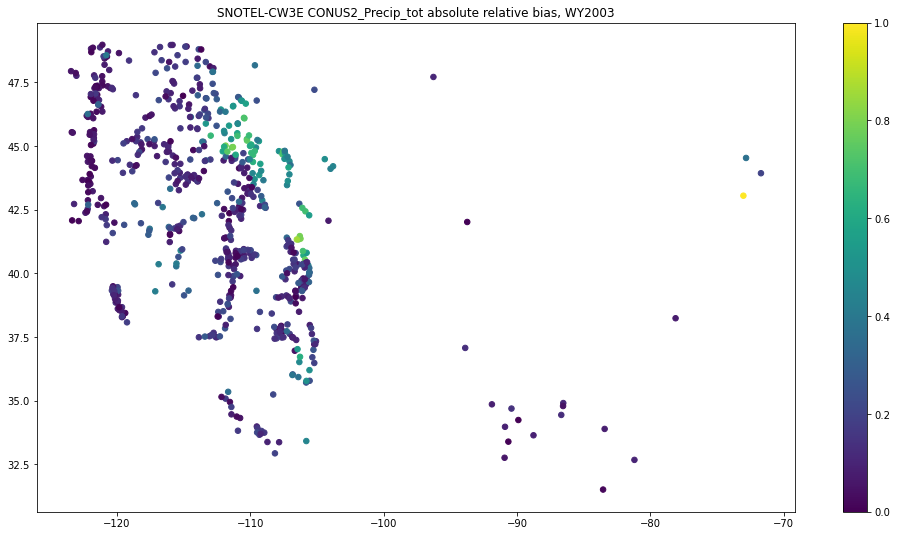

In [28]:
### Absolute Relative Bias
### Good values are closer to 0.0
fig = plt.figure(figsize=(17,9), dpi=72)
plt.scatter(stats_df.longitude,stats_df.latitude, c=stats_df.absrelbias, s=30, vmin = 0, vmax = 1)
plt.colorbar()
plt.title(f'SNOTEL-CW3E {variable} absolute relative bias, WY{water_year}')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_{variable}_AbsRelBias_Map.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

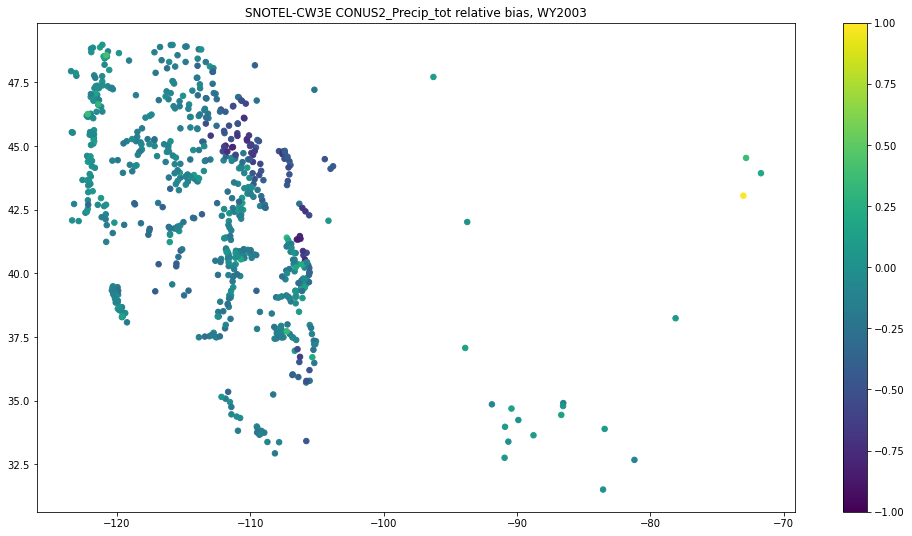

In [29]:
### Relative Bias
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig = plt.figure(figsize=(17,9), dpi=72)
plt.scatter(stats_df.longitude,stats_df.latitude, c=stats_df.bias, s=30, vmin = -1, vmax = 1)
plt.colorbar()
plt.title(f'SNOTEL-CW3E {variable} relative bias, WY{water_year}')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_{variable}_RelBias_Map.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

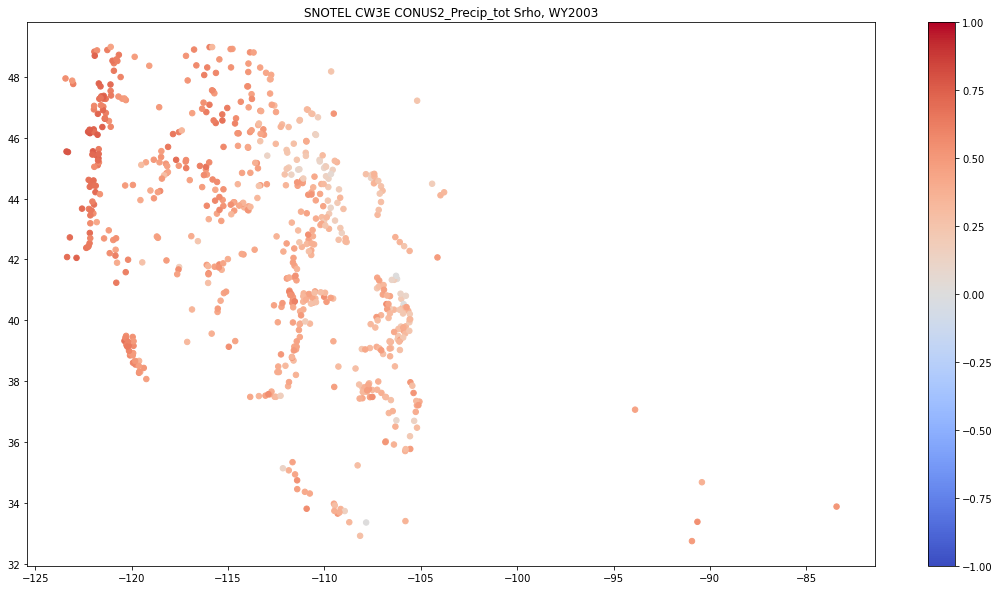

In [30]:
fig = plt.figure(figsize=(19,10), dpi=72)
plt.scatter(stats_df.longitude,stats_df.latitude, c=stats_df.srho, s=30, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.colorbar()
plt.title(f'SNOTEL CW3E {variable} Srho, WY{water_year}')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_{variable}_SpearmansRho_Map.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")
    

## Make SNOTEL-CONUS2 timeseries plots 
Plot a timeseries at each station for SNOTEL Temperature observations and PF-CONUS2

In [ ]:
len(snotel_data.columns)

In [31]:
### Make a plot of CONUS2 vs observed
xlength = range(len(snotel_data.columns))
xlength = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in pfdata.columns]

for i in range(3):#range(len(pfdata.index)):
    gage = snotel_data.index[i]
    station_name = snotel_metadata['site_name'][gage]
    state = snotel_metadata['state'][gage]

    # make hydrographs
    fig, ax = plt.subplots(figsize=(7,5), dpi = 200)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.plot(xlength, pfdata.loc[gage],label= 'CW3E')
    ax.plot(xlength, snotel_data.loc[gage],label= 'SNOTEL')
    #plt.gcf().autofmt_xdate()
    ax.set_ylabel('precip [mm]')
    #plt.xlabel('Days')
    plt.title(f'Total Daily Precipitation - {station_name}, {state}')
    plt.annotate(f'Bias: {round(stats_df.bias.iloc[i],3)}\nSrho: {round(stats_df.srho.iloc[i],3)}',\
                 xy=(0.05, 0.77), xycoords = 'axes fraction')
    ax.legend()
    
    # Save plots in the plot dir, create a new folder here
    plt.savefig(f'{plot_dir}/Timeseries_2003_Precip_SNOTEL/Timeseries_{variable}_{snotel_data.index[i]}_cms.png',\
                facecolor='white', transparent=False, bbox_inches="tight")
    plt.close()

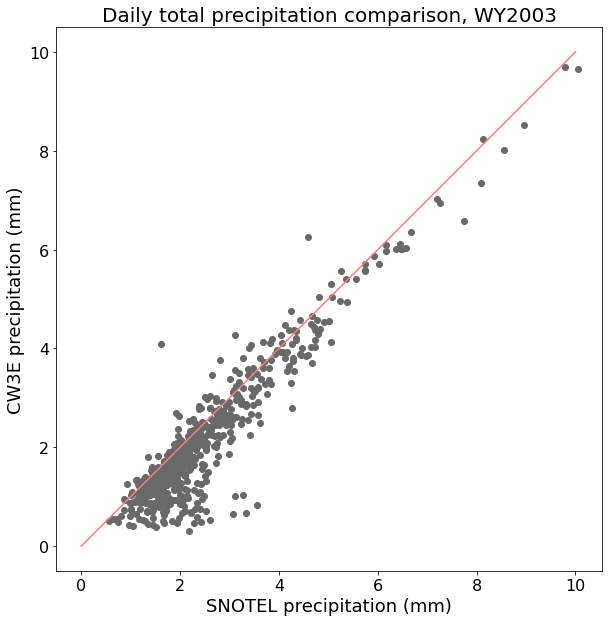

In [8]:
# Scatter plot of daily mean flow for  WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(stats_df['SNOTEL_meanTotal_P_mm'], stats_df['CW3E_meanTotal_P_mm'], color = 'dimgrey')
ax.plot(range(11), color = 'lightcoral')
plt.xlabel('SNOTEL precipitation (mm)',fontsize=18)
plt.ylabel('CW3E precipitation (mm)',fontsize=18)
plt.title('Daily total precipitation comparison, WY2003',fontsize=20)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'{plot_dir}/SNOTEL_CW3E_totalPrecip_scatter_WY{water_year}.png')


### Geopandas Test Code

In [56]:
# Create a GeoDataFrame from a CSV file with longitude and latitude columns
df = pd.read_csv(f'{organized_dir}/Summary_Stations_SNOTEL_{variable}_CONUS2_WY{water_year}.csv')
geometry = gpd.points_from_xy(df.longitude, df.latitude)
gdf = gpd.GeoDataFrame(df,crs = 'EPSG:4326', geometry=geometry)

In [57]:
gdf_lcc = gdf.copy()
gdf_lcc = gdf_lcc.to_crs("+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40.00000762944445 +lon_0=-97 +x_0=0 +y_0=0 +a=6370000 +b=6370000 +units=m +no_defs")

In [59]:
gdf_lcc.crs

<Projected CRS: +proj=lcc +lat_1=30 +lat_2=60 +lat_0=40.0000076294 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [43]:
gdf = gdf.to_crs(epsg=4326)

In [71]:
gdf_lcc.crs

<Projected CRS: +proj=lcc +lat_1=30 +lat_2=60 +lat_0=40.0000076294 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

In [46]:
type(shapefile)

geopandas.geodataframe.GeoDataFrame

In [47]:
shp_dir = '/glade/p/univ/ucsm0009/CONUS2/domain_files/CONUS2_domain_LCC.shp'

In [60]:
# Read in the shapefile
shapefile = gpd.read_file(shp_dir)
shapefile = shapefile.to_crs('+proj=lcc +lat_1=30 +lat_2=60 +lat_0=40.00000762944445 +lon_0=-97 +x_0=0 +y_0=0 +a=6370000 +b=6370000 +units=m +no_defs')


In [61]:
shapefile.crs

<Projected CRS: +proj=lcc +lat_1=30 +lat_2=60 +lat_0=40.0000076294 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

<AxesSubplot:>

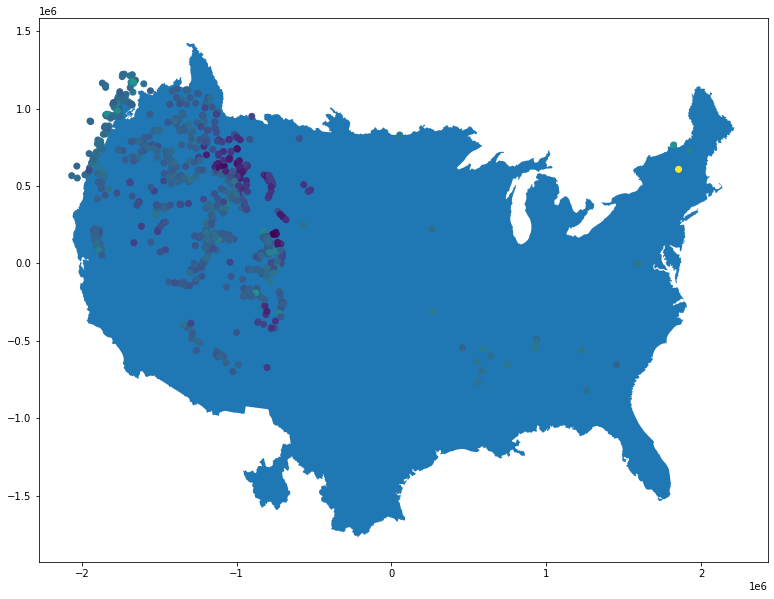

In [70]:
# Plot the shapefile
ax = shapefile.plot()

# Plot the GeoDataFrame on top of the shapefile
#fig, ax = plt.subplots(1, 1, figsize=(15, 12), dpi=72)
#gdf_lcc["figure.figsize"] = (20,10)
gdf_lcc.plot(ax=ax, column='bias')

In [14]:
gdf

,site_id,site_name,state,latitude,longitude,conus2_x,conus2_y,SNOTEL_meanTotal_P_mm,CW3E_meanTotal_P_mm,absrelbias,bias,pbias,srho,geometry
0,1000:OR:SNTL,Annie Springs,OR,42.87007,-122.16518,258,2286,4.349315,4.174912,0.040099,-0.040099,-4.009888,0.693892,POINT (-122.16518 42.87007)
1,1005:CO:SNTL,Ute Creek,CO,37.61480,-105.37322,1490,1448,2.546959,2.244455,0.118771,-0.118771,-11.877051,0.519944,POINT (-105.37322 37.61480)
2,1006:NV:SNTL,Lewis Peak,NV,40.35720,-116.86470,592,1908,1.461370,0.841760,0.423992,-0.423992,-42.399245,0.343925,POINT (-116.86470 40.35720)
3,1008:MT:SNTL,Onion Park,MT,46.91348,-110.85360,1196,2499,2.025041,1.272229,0.371752,-0.371752,-37.175152,0.340409,POINT (-110.85360 46.91348)
4,1009:MT:SNTL,Stringer Creek,MT,46.92690,-110.90198,1193,2501,1.858027,1.348236,0.274372,-0.274372,-27.437236,0.332799,POINT (-110.90198 46.92690)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
657,985:WA:SNTL,Sourdough Gulch,WA,46.23718,-117.39438,709,2531,1.148219,1.081542,0.058070,-0.058070,-5.806988,0.339830,POINT (-117.39438 46.23718)
658,988:ID:SNTL,Hidden Lake,ID,48.89370,-116.75748,825,2796,4.161425,3.545601,0.147984,-0.147984,-14.798388,0.579411,POINT (-116.75748 48.89370)
659,989:ID:SNTL,Moscow Mountain,ID,46.80500,-116.85350,763,2580,2.533041,1.941709,0.233447,-0.233447,-23.344730,0.460922,POINT (-116.85350 46.80500)
660,990:WA:SNTL,Beaver Pass,WA,48.87930,-121.25550,518,2881,4.244932,4.748587,0.118649,0.118649,11.864863,0.624450,POINT (-121.25550 48.87930)
